In [ ]:
!gdown 1zRHT9eSFUNK6o3AHwQmyAeFzXfEzkEts
!unzip vqa_coco_dataset.zip -d /kaggle/working/vqa_coco_dataset

In [ ]:
!pip uninstall -y torch torchvision
!pip install torch torchvision torchtext==0.17.2

In [4]:
import os
import random
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from PIL import Image
import timm
from sklearn.model_selection import train_test_split
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## Train Val Test Split

In [6]:
def load_data(data_path):
    """Load and process data from a text file."""
    data = []
    with open(data_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            temp = line.split("\t") # Split into image path and QA text
            qa = temp[1].split("?") # Split QA into question and answers
            image_path = temp[0][:-2] # Remove '#0' from image path
            
            # Extract the answer depending on the length of the split QA list
            answer = qa[2].strip() if len(qa) == 3 else qa[1].strip()

            data.append({
                "image_path": image_path,
                "question": qa[0] + "?",
                "answer": answer
            })
    return data

In [7]:
train_path = "/kaggle/working/vqa_coco_dataset/vaq2.0.TrainImages.txt"
val_path = "/kaggle/working/vqa_coco_dataset/vaq2.0.DevImages.txt"
test_path = "/kaggle/working/vqa_coco_dataset/vaq2.0.TestImages.txt"

train_data = load_data(train_path)
val_data = load_data(val_path)
test_data = load_data(test_path)

len(train_data), len(val_data), len(test_data)

(7846, 1952, 2022)

## Build Vocabulary

In [8]:
spacy.prefer_gpu() # Enable spaCy to use GPU if available
eng = spacy.load("en_core_web_sm") # Load the English tokenizer from spaCy
 
def get_tokens(data_iter):
    """Tokenizes question field in each sample"""
    for sample in data_iter:
        question = sample["question"] # Extract the question text
        yield [token.text for token in eng.tokenizer(question)] # Tokenize and yield tokens as a list


# Build a vocabulary from the tokenized questions
vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq = 2,
    specials=("<unk>", "<pad>", "<bos>", "<eos>"),
    special_first=True,
)
# Set the default token index for unknown tokens to <unk>
vocab.set_default_index(vocab["<unk>"])

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 1678


## Dictionary mapping classes

In [9]:
classes = set([sample["answer"] for sample in train_data])
print("Classes: ", classes)

label2idx = {cls_name : idx for idx, cls_name in enumerate(classes)}
idx2label = {idx: cls_name for idx, cls_name in enumerate(classes)}

print(label2idx)
print(idx2label)

Classes:  {'yes', 'no'}
{'yes': 0, 'no': 1}
{0: 'yes', 1: 'no'}


## Build Tokenization Function for Input Question

In [10]:
def tokenize(question, max_seq_len, vocab):
    """Tokenizes a question and converts it to a fixed-length index sequence."""
    tokens = [token.text for token in eng.tokenizer(question)] # Tokenize question
    sequence = [vocab[token] for token in tokens] # Map tokens to indices

    # Pad or truncate to max_seq_len
    if len(sequence) < max_seq_len:
        sequence += [vocab["<pad>"]] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence


def detokenize(sequence, vocab):
    """Converts an index sequence back to a string, removing special tokens."""
    idx_to_token = vocab.get_itos() # Get index-to-token mapping
    tokens = [idx_to_token[idx] for idx in sequence if idx_to_token[idx] not in ['<pad>', '<sos>', '<eos>', '<unk>']]

    return " ".join(tokens)

## VQA Dataset and DataLoader Setup

### VQADataset Class Definition

In [16]:
class VQADataset(Dataset):
    def __init__(self, data, label2idx, max_seq_len=20, vocab=vocab, transform=None, img_dir="/kaggle/working/vqa_coco_dataset/val2014-resised"):
        self.data = data
        self.label2idx = label2idx
        self.max_seq_len = max_seq_len
        self.vocab = vocab
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Preprocess the image
        img_path = os.path.join(self.img_dir, self.data[index]["image_path"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Tokenize the question
        question = tokenize(self.data[index]["question"], self.max_seq_len, self.vocab)
        question = torch.tensor(question, dtype=torch.long)

        # Convert the label to an index
        label = self.label2idx[self.data[index]["answer"]]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

### Data Transformations


In [17]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.CenterCrop(size=180),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

### Dataset Initialization

In [18]:
train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    transform=data_transform["train"]
)

val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    transform=data_transform["val"]
)

test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    transform=data_transform["val"]
)

len(train_dataset), len(val_dataset), len(test_dataset)

(7846, 1952, 2022)

### DataLoader Setup

In [19]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

len(train_loader), len(val_loader), len(test_loader)

(31, 61, 64)

## Build Model

In [20]:
class VQAModel(nn.Module):
    def __init__(self, n_classes, img_model_name, embedding_dim, n_layers=2, hidden_size=256, drop_prob=0.2):
        super(VQAModel, self).__init__()
        
        # Pre-trained image model
        self.image_encoder = timm.create_model(img_model_name, pretrained=True, num_classes=hidden_size)
        for param in self.image_encoder.parameters():
            param.requires_grad = True

        # Text embedding layer
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        
        # Bidirectional LSTM for text
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=drop_prob
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 3, hidden_size)
        self.dropout = nn.Dropout(drop_prob)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, img, text):
        # Image features
        img_features = self.image_encoder(img)

        # Text features
        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm(text_emb)
        lstm_out = lstm_out[:, -1, :]

        # Concatenate image and text features
        combined = torch.cat((img_features, lstm_out), dim=1)

        # Fully connected layers
        x = self.fc1(combined)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [23]:
n_classes = len(classes)
img_model_name = "resnet18"
hidden_size = 256
n_layers = 2
embedding_dim = 128
drop_prob = 0.2
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embedding_dim=embedding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_prob=drop_prob
).to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [24]:
images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([256, 2])


## Train and Evaluate funtion

In [25]:
def evaluate(moel, dataloader, criterion, device):
    correct, total = 0, 0
    losses = []

    model.eval()
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)

            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1) # Get predicted label

            total += labels.size(0)
            correct += (predicted == labels).sum().item() # Count correct predictions

    loss = np.mean(losses)
    acc = correct / total

    return loss, acc

In [26]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        total, correct = 0, 0
        batch_train_losses = []

        model.train()
        for images, questions, labels in train_loader:
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1) # Get predictions

            total += labels.size(0)
            correct += (predicted == labels).sum().item() # Count correct predictions

        train_loss = np.mean(batch_train_losses)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Step the learning rate scheduler
        scheduler.step()
    return train_losses, train_accs, val_losses, val_accs

In [27]:
lr = 1e-3
epochs = 50

scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.1)

train_losses, train_accs, val_losses, val_accs = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

Epoch: 1/50 | Train Loss: 0.6955 | Train Acc: 0.5071 | Val Loss: 0.6925 | Val Acc: 0.5118
Epoch: 2/50 | Train Loss: 0.6836 | Train Acc: 0.5546 | Val Loss: 0.6917 | Val Acc: 0.5353
Epoch: 3/50 | Train Loss: 0.6556 | Train Acc: 0.6132 | Val Loss: 0.7183 | Val Acc: 0.5056
Epoch: 4/50 | Train Loss: 0.6031 | Train Acc: 0.6773 | Val Loss: 0.6980 | Val Acc: 0.5579
Epoch: 5/50 | Train Loss: 0.5189 | Train Acc: 0.7452 | Val Loss: 0.8222 | Val Acc: 0.5297
Epoch: 6/50 | Train Loss: 0.4375 | Train Acc: 0.8026 | Val Loss: 0.7476 | Val Acc: 0.5820
Epoch: 7/50 | Train Loss: 0.3755 | Train Acc: 0.8422 | Val Loss: 0.7598 | Val Acc: 0.5907
Epoch: 8/50 | Train Loss: 0.3244 | Train Acc: 0.8697 | Val Loss: 0.7787 | Val Acc: 0.5835
Epoch: 9/50 | Train Loss: 0.2860 | Train Acc: 0.8894 | Val Loss: 0.7541 | Val Acc: 0.5927
Epoch: 10/50 | Train Loss: 0.2488 | Train Acc: 0.9034 | Val Loss: 0.8937 | Val Acc: 0.5871
Epoch: 11/50 | Train Loss: 0.2307 | Train Acc: 0.9119 | Val Loss: 0.8474 | Val Acc: 0.6276
Epoch: 1

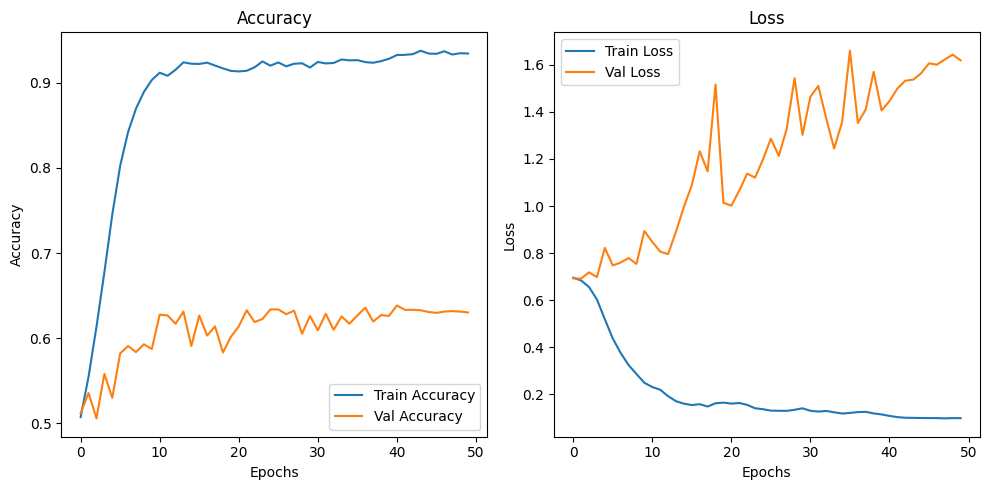

In [28]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [29]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6301229508196722
Test accuracy:  0.655786350148368


In [36]:
idx = 22
img_name = test_data[idx]["image_path"]
img_path = os.path.join("/kaggle/working/vqa_coco_dataset/val2014-resised", img_name)
question = test_data[idx]["question"]
answer = test_data[idx]["answer"]

img_path, question, answer

('/kaggle/working/vqa_coco_dataset/val2014-resised/COCO_val2014_000000525646.jpg',
 'Is this a pizza ?',
 'yes')

In [56]:
img =  Image.open(img_path).convert("RGB")
img_processed = data_transform["val"](img).unsqueeze(0).to(device)

max_seq_len = 20
question_processed = torch.tensor(tokenize(question, max_seq_len, vocab)).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item()

reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.299, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    transforms.ToPILImage()
])
img_vis = reverse_transform(img_processed.squeeze(0).cpu())

origin_quest = detokenize(question_processed.squeeze(0).cpu().tolist(), vocab)

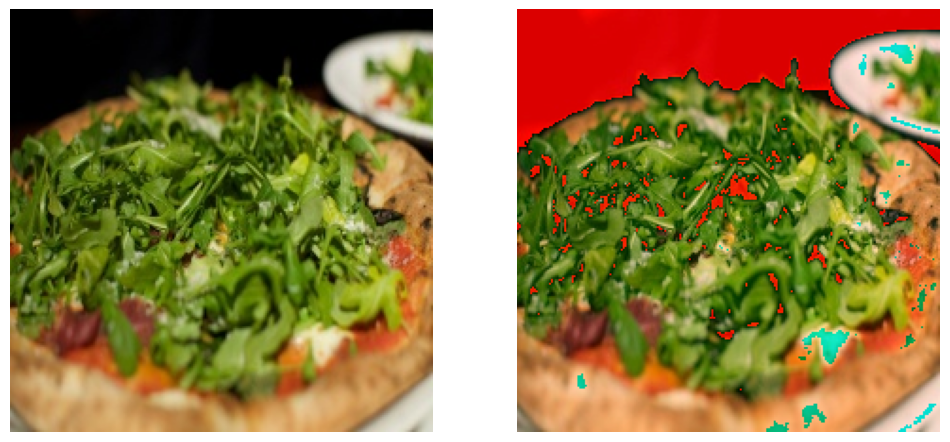

Question: Is this a pizza ?
Groundtruth: yes
Predicted: yes


In [58]:
plt.figure(figsize=(12, 6)) 

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_vis)
plt.axis("off")
plt.show()

print(f"Question: {origin_quest}")
print(f"Groundtruth: {answer}")
print(f"Predicted: {idx2label[pred]}")